In [1]:
import sys, os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# import pickle as pk
import numpy as np
import torch
dev = torch.device("cuda")
import torch.optim as optim
# from torch.distributions import MultivariateNormal
# from torch.distributions import Normal
root_dir = '/mnt/home/spandey/ceph/AR_NPE/'
os.chdir(root_dir)
# import colossus
import sys, os
# append the root_dir to the path
sys.path.append(root_dir)
from nf.combined_models import COMBINED_Model
from nf.all_models import *
from nf.utils_data_prep import *
# from tqdm import tqdm
# import pyyaml
from colossus.cosmology import cosmology
params = {'flat': True, 'H0': 67.11, 'Om0': 0.3175, 'Ob0': 0.049, 'sigma8': 0.834, 'ns': 0.9624}
cosmo = cosmology.setCosmology('myCosmo', **params)
# get halo mass function:
from colossus.lss import mass_function
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as pl
pl.rc('text', usetex=True)
# Palatino
pl.rc('font', family='DejaVu Sans')
%matplotlib inline
import yaml

# autoreload modules
%load_ext autoreload
%autoreload 2



In [6]:
import readfof
import sys, os
import numpy as np
import pickle as pk 
# from nbodykit.lab import *
import h5py as h5
import numpy as np
import Pk_library as PKL
import MAS_library as MASL
import yaml

# isim_all = [30]
isim_all = np.arange(0,1100)
# isim_all = np.arange(300,520)
ns_h = 128
ldir = '/mnt/home/spandey/ceph/AR_NPE/SAVE_CATS_TEST_CMASS/'

kmax = 0.32
nk = 16
threads = 10

sdir_stats = '/mnt/home/spandey/ceph/AR_NPE/SAVE_STATS_TEST_CMASS/'

for ji in range(len(isim_all)):
    isim = isim_all[ji]
    grid    = ns_h    #the 3D field will have grid x grid x grid voxels
    BoxSize = 1000.0 #Mpc/h ; size of box
    MAS     = 'NGP'  #mass-assigment scheme
    verbose = False   #print information on progress
    savefname = sdir_stats + '/saved_stats_halos_' + str(isim) + '_CMASS.pk'
    savefname_final = sdir_stats + '/saved_stats_halos_with_MASS_WEIGHTED_' + str(isim) + '_CMASS.pk'
    # if file does not exist:
    saved = pk.load(open(ldir + '/saved_halo_only_' + str(isim) + '_CMASS.pk', 'rb'))
    # saved = {'pos_h_truth': pos_h_truth, 'lgMass_truth': lgMass_truth, 'pos_h_mock': pos_h_mock, 'lgMass_mock': lgMass_mock, 'cosmo':cosmo_val_all_test[0,0,0,0,:]}
    pos_h_truth = saved['pos_h_truth']
    lgMass_truth = saved['lgMass_truth']
    pos_h_mock = saved['pos_h_mock']
    lgMass_mock = saved['lgMass_mock']
    cosmo = saved['cosmo']
    Mmin_Pk, Mmax_Pk = 13.0, 16.0


    # if not os.path.isfile(savefname):

    # for j in range(len(Mmin_Pk_all)):
    saved_j = {}
    # Mmin_Pk, Mmax_Pk = Mmin_Pk_all[j], Mmax_Pk_all[j]

    indsel_Pk_truth = np.where((lgMass_truth > Mmin_Pk) & (lgMass_truth < Mmax_Pk))[0]
    mesh_truth2 = np.zeros((grid, grid, grid), dtype=np.float32)
    pos_truth2 = (pos_h_truth[indsel_Pk_truth,...]).astype(np.float32)
    MASL.MA(pos_truth2, mesh_truth2, BoxSize, MAS)
    mesh_truth2 /= np.mean(mesh_truth2, dtype=np.float64);  mesh_truth2 -= 1.0
    Pk_truth2 = PKL.Pk(mesh_truth2, BoxSize, axis=0, MAS=None, threads=threads)

    indsel_Pk_mock = np.where((lgMass_mock > Mmin_Pk) & (lgMass_mock < Mmax_Pk))[0]
    mesh_mock = np.zeros((grid, grid, grid), dtype=np.float32)
    pos_mock = (pos_h_mock[indsel_Pk_mock,...]).astype(np.float32)
    MASL.MA(pos_mock, mesh_mock, BoxSize, MAS)
    mesh_mock /= np.mean(mesh_mock, dtype=np.float64);  mesh_mock -= 1.0
    Pk_mock = PKL.Pk(mesh_mock, BoxSize, axis=0, MAS=None, threads=threads)
    
    indk_sel = np.where((Pk_truth2.k3D >= 0.01) & (Pk_truth2.k3D <= kmax))[0]
    Pkmock_sel = Pk_mock.Pk[indk_sel,0]
    Pktruth_sel = Pk_truth2.Pk[indk_sel,0]
    k_Pk = Pk_truth2.k3D[indk_sel]

    len_k_sel = len(indk_sel)
    ds_fac = len_k_sel//nk
    Pk_mock_ds = Pkmock_sel[::ds_fac]
    Pk_truth_ds = Pktruth_sel[::ds_fac]
    k_Pk_ds = k_Pk[::ds_fac]

    saved_j['Pk_truth'] = Pk_truth_ds
    saved_j['Pk_mock'] = Pk_mock_ds
    saved_j['k_Pk'] = k_Pk_ds       

    BoxSize = 1000.0 #Size of the density field in Mpc/h

    theta   = np.linspace(0.1, np.pi-0.1, 8) #array with the angles between k1 and k2
    saved_j['theta'] = theta

    k1 = 0.08
    k2 = 0.08
    BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
    Bk_truth_k0p06  = BBk.B     #bispectrum
    Qk_truth_k0p06  = BBk.Q     #reduced bispectrum
    BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
    Bk_mock_k0p06  = BBk.B     #bispectrum
    Qk_mock_k0p06  = BBk.Q     #reduced bispectrum

    saved_j['Bk_truth_k0p06'] = Bk_truth_k0p06
    saved_j['Qk_truth_k0p06'] = Qk_truth_k0p06
    saved_j['Bk_mock_k0p06'] = Bk_mock_k0p06
    saved_j['Qk_mock_k0p06'] = Qk_mock_k0p06

    k1 = 0.16
    k2 = 0.16
    BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
    Bk_truth_k0p2  = BBk.B     #bispectrum
    Qk_truth_k0p2  = BBk.Q     #reduced bispectrum
    BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
    Bk_mock_k0p2  = BBk.B     #bispectrum
    Qk_mock_k0p2  = BBk.Q     #reduced bispectrum

    saved_j['Bk_truth_k0p2'] = Bk_truth_k0p2
    saved_j['Qk_truth_k0p2'] = Qk_truth_k0p2
    saved_j['Bk_mock_k0p2'] = Bk_mock_k0p2
    saved_j['Qk_mock_k0p2'] = Qk_mock_k0p2


    k1 = 0.32
    k2 = 0.32
    BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
    Bk_truth_k0p3  = BBk.B     #bispectrum
    Qk_truth_k0p3  = BBk.Q     #reduced bispectrum
    BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
    Bk_mock_k0p3  = BBk.B     #bispectrum
    Qk_mock_k0p3  = BBk.Q     #reduced bispectrum

    saved_j['Bk_truth_k0p3'] = Bk_truth_k0p3
    saved_j['Qk_truth_k0p3'] = Qk_truth_k0p3
    saved_j['Bk_mock_k0p3'] = Bk_mock_k0p3
    saved_j['Qk_mock_k0p3'] = Qk_mock_k0p3

    summary_concat_mock_all = np.concatenate((Pk_mock_ds, Bk_mock_k0p06, Bk_mock_k0p2, Bk_mock_k0p3))
    summary_concat_truth_all = np.concatenate((Pk_truth_ds, Bk_truth_k0p06, Bk_truth_k0p2, Bk_truth_k0p3))
    saved_j['summary_concat_mock_all'] = summary_concat_mock_all
    saved_j['summary_concat_truth_all'] = summary_concat_truth_all
    saved_j['cosmo'] = cosmo
    # pk.dump(saved_j, open(savefname, 'wb'))
    
    # else:
    #     print('loaded already calc unweighted')
    #     saved_j = pk.load(open(savefname, 'rb'))

    indsel_Pk_truth = np.where((lgMass_truth > Mmin_Pk) & (lgMass_truth < Mmax_Pk))[0]
    mesh_truth2 = np.zeros((grid, grid, grid), dtype=np.float32)
    pos_truth2 = (pos_h_truth[indsel_Pk_truth,...]).astype(np.float32)
    MASL.MA(pos_truth2, mesh_truth2, BoxSize, MAS, W=10**((lgMass_truth[indsel_Pk_truth]- Mmax_Pk)))
    mesh_truth2 /= np.mean(mesh_truth2, dtype=np.float64);  mesh_truth2 -= 1.0
    Pk_truth2 = PKL.Pk(mesh_truth2, BoxSize, axis=0, MAS=None, threads=threads)

    indsel_Pk_mock = np.where((lgMass_mock > Mmin_Pk) & (lgMass_mock < Mmax_Pk))[0]
    mesh_mock = np.zeros((grid, grid, grid), dtype=np.float32)
    pos_mock = (pos_h_mock[indsel_Pk_mock,...]).astype(np.float32)
    MASL.MA(pos_mock, mesh_mock, BoxSize, MAS, W=10**((lgMass_mock[indsel_Pk_mock]- Mmax_Pk)))
    mesh_mock /= np.mean(mesh_mock, dtype=np.float64);  mesh_mock -= 1.0
    Pk_mock = PKL.Pk(mesh_mock, BoxSize, axis=0, MAS=None, threads=threads)
    
    indk_sel = np.where((Pk_truth2.k3D >= 0.01) & (Pk_truth2.k3D <= kmax))[0]
    Pkmock_sel = Pk_mock.Pk[indk_sel,0]
    Pktruth_sel = Pk_truth2.Pk[indk_sel,0]

    k_Pk = Pk_truth2.k3D[indk_sel]

    len_k_sel = len(indk_sel)
    ds_fac = len_k_sel//nk
    Pk_mock_ds = Pkmock_sel[::ds_fac]
    Pk_truth_ds = Pktruth_sel[::ds_fac]
    k_Pk_ds = k_Pk[::ds_fac]

    saved_j['Pk_truth_weighted'] = Pk_truth_ds
    saved_j['Pk_mock_weighted'] = Pk_mock_ds
    saved_j['k_Pk_weighted'] = k_Pk_ds

    BoxSize = 1000.0 #Size of the density field in Mpc/h
    # threads = 1
    theta   = np.linspace(0.1, np.pi-0.1, 8) #array with the angles between k1 and k2
    saved_j['theta'] = theta

    k1 = 0.08
    k2 = 0.08
    BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
    Bk_truth_k0p06  = BBk.B     #bispectrum
    Qk_truth_k0p06  = BBk.Q     #reduced bispectrum
    BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
    Bk_mock_k0p06  = BBk.B     #bispectrum
    Qk_mock_k0p06  = BBk.Q     #reduced bispectrum

    saved_j['Bk_truth_k0p06_weighted'] = Bk_truth_k0p06
    saved_j['Qk_truth_k0p06_weighted'] = Qk_truth_k0p06
    saved_j['Bk_mock_k0p06_weighted'] = Bk_mock_k0p06
    saved_j['Qk_mock_k0p06_weighted'] = Qk_mock_k0p06

    k1 = 0.16
    k2 = 0.16
    BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
    Bk_truth_k0p2  = BBk.B     #bispectrum
    Qk_truth_k0p2  = BBk.Q     #reduced bispectrum
    BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
    Bk_mock_k0p2  = BBk.B     #bispectrum
    Qk_mock_k0p2  = BBk.Q     #reduced bispectrum

    saved_j['Bk_truth_k0p2_weighted'] = Bk_truth_k0p2
    saved_j['Qk_truth_k0p2_weighted'] = Qk_truth_k0p2
    saved_j['Bk_mock_k0p2_weighted'] = Bk_mock_k0p2
    saved_j['Qk_mock_k0p2_weighted'] = Qk_mock_k0p2


    k1 = 0.32
    k2 = 0.32
    BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
    Bk_truth_k0p3  = BBk.B     #bispectrum
    Qk_truth_k0p3  = BBk.Q     #reduced bispectrum
    BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
    Bk_mock_k0p3  = BBk.B     #bispectrum
    Qk_mock_k0p3  = BBk.Q     #reduced bispectrum

    saved_j['Bk_truth_k0p3_weighted'] = Bk_truth_k0p3
    saved_j['Qk_truth_k0p3_weighted'] = Qk_truth_k0p3
    saved_j['Bk_mock_k0p3_weighted'] = Bk_mock_k0p3
    saved_j['Qk_mock_k0p3_weighted'] = Qk_mock_k0p3


    summary_concat_mock_all_weighted = np.concatenate((Pk_mock_ds, Bk_mock_k0p06, Bk_mock_k0p2, Bk_mock_k0p3))
    summary_concat_truth_all_weighted = np.concatenate((Pk_truth_ds, Bk_truth_k0p06, Bk_truth_k0p2, Bk_truth_k0p3))

    summary_concat_mock_all_unw_weigthed = np.concatenate((saved_j['summary_concat_mock_all'], summary_concat_mock_all_weighted))
    summary_concat_truth_all_unw_weigthed = np.concatenate((saved_j['summary_concat_truth_all'], summary_concat_truth_all_weighted))

    if np.all(np.isfinite(summary_concat_mock_all_unw_weigthed)) and np.all(np.isfinite(summary_concat_truth_all_unw_weigthed)):
        saved_j['summary_concat_mock_all_unweighted_weighted'] = summary_concat_mock_all_unw_weigthed
        saved_j['summary_concat_truth_all_unweighted_weighted'] = summary_concat_truth_all_unw_weigthed
        saved_j['cosmo'] = cosmo
        pk.dump(saved_j, open(savefname_final, 'wb'))
        print('saved_with_weighting')
    # else:
        # pass

# saved_Pk_Bk[j] = saved_j



Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.06 seconds

Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.06 seconds

Computing bispectrum of the field...


Time to compute bispectrum = 0.22

Computing bispectrum of the field...
Time to compute bispectrum = 0.20

Computing bispectrum of the field...
Time to compute bispectrum = 0.19

Computing bispectrum of the field...
Time to compute bispectrum = 0.24

Computing bispectrum of the field...
Time to compute bispectrum = 0.19

Computing bispectrum of the field...
Time to compute bispectrum = 0.20

Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.06 seconds

Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.06 seconds

Computing bispectrum of the field...
Time to compute bispectrum = 0.18

Computing bispectrum of the field...
Time to compute bispectrum = 0.18

Computing bispectrum of the field...
Time to compute bispectrum = 0.19

Computing bispectrum of the field...
Time to compute bispectrum = 0.21

Computing bispectrum of the field...
Time to compute bispectrum = 0.35

Computing bispectrum of the field...
Time to comput

In [4]:
# ds_fac
# Pkmock_sel.shape
k_Pk[::ds_fac]


array([0.01507912, 0.034351  , 0.05308225, 0.07196633, 0.09096855,
       0.10975764, 0.12868173, 0.14751336, 0.16639912, 0.18523537,
       0.20409377, 0.22297003, 0.24179106, 0.26063343, 0.27955297,
       0.29834498, 0.31721682])

In [5]:
import readfof
import sys, os
import numpy as np
import pickle as pk 
# from nbodykit.lab import *
import h5py as h5
import numpy as np
import Pk_library as PKL
import MAS_library as MASL
import yaml

# isim_all = [30]
isim_all = np.arange(0,1100)
# isim_all = np.arange(300,520)
ns_h = 128
ldir = '/mnt/home/spandey/ceph/AR_NPE/SAVE_CATS_TEST_CMASS/'

kmax = 0.32
nk = 16
threads = 10

sdir_stats = '/mnt/home/spandey/ceph/AR_NPE/SAVE_STATS_TEST_CMASS/'
ji = 0
# for ji in range(len(isim_all)):
isim = isim_all[ji]
grid    = ns_h    #the 3D field will have grid x grid x grid voxels
BoxSize = 1000.0 #Mpc/h ; size of box
MAS     = 'NGP'  #mass-assigment scheme
verbose = False   #print information on progress
savefname = sdir_stats + '/saved_stats_halos_' + str(isim) + '_CMASS.pk'
savefname_final = sdir_stats + '/saved_stats_halos_with_MASS_WEIGHTED_' + str(isim) + '_CMASS.pk'
# if file does not exist:
saved = pk.load(open(ldir + '/saved_halo_only_' + str(isim) + '_CMASS.pk', 'rb'))
# saved = {'pos_h_truth': pos_h_truth, 'lgMass_truth': lgMass_truth, 'pos_h_mock': pos_h_mock, 'lgMass_mock': lgMass_mock, 'cosmo':cosmo_val_all_test[0,0,0,0,:]}
pos_h_truth = saved['pos_h_truth']
lgMass_truth = saved['lgMass_truth']
pos_h_mock = saved['pos_h_mock']
lgMass_mock = saved['lgMass_mock']
cosmo = saved['cosmo']
Mmin_Pk, Mmax_Pk = 13.0, 16.0


if not os.path.isfile(savefname):

    # for j in range(len(Mmin_Pk_all)):
    saved_j = {}
    # Mmin_Pk, Mmax_Pk = Mmin_Pk_all[j], Mmax_Pk_all[j]

    indsel_Pk_truth = np.where((lgMass_truth > Mmin_Pk) & (lgMass_truth < Mmax_Pk))[0]
    mesh_truth2 = np.zeros((grid, grid, grid), dtype=np.float32)
    pos_truth2 = (pos_h_truth[indsel_Pk_truth,...]).astype(np.float32)
    MASL.MA(pos_truth2, mesh_truth2, BoxSize, MAS)
    mesh_truth2 /= np.mean(mesh_truth2, dtype=np.float64);  mesh_truth2 -= 1.0
    Pk_truth2 = PKL.Pk(mesh_truth2, BoxSize, axis=0, MAS=None, threads=threads)

    indsel_Pk_mock = np.where((lgMass_mock > Mmin_Pk) & (lgMass_mock < Mmax_Pk))[0]
    mesh_mock = np.zeros((grid, grid, grid), dtype=np.float32)
    pos_mock = (pos_h_mock[indsel_Pk_mock,...]).astype(np.float32)
    MASL.MA(pos_mock, mesh_mock, BoxSize, MAS)
    mesh_mock /= np.mean(mesh_mock, dtype=np.float64);  mesh_mock -= 1.0
    Pk_mock = PKL.Pk(mesh_mock, BoxSize, axis=0, MAS=None, threads=threads)
    
    indk_sel = np.where((Pk_truth2.k3D >= 0.01) & (Pk_truth2.k3D <= kmax))[0]
    Pkmock_sel = Pk_mock.Pk[indk_sel,0]
    Pktruth_sel = Pk_truth2.Pk[indk_sel,0]
    k_Pk = Pk_truth2.k3D[indk_sel]

    len_k_sel = len(indk_sel)
    ds_fac = len_k_sel//nk
    Pk_mock_ds = Pkmock_sel[::ds_fac,0]
    Pk_truth_ds = Pktruth_sel[::ds_fac,0]
    k_Pk_ds = k_Pk[::ds_fac]

    saved_j['Pk_truth'] = Pk_truth_ds
    saved_j['Pk_mock'] = Pk_mock_ds
    saved_j['k_Pk'] = k_Pk_ds        

    BoxSize = 1000.0 #Size of the density field in Mpc/h

    theta   = np.linspace(0.1, np.pi-0.1, 8) #array with the angles between k1 and k2
    saved_j['theta'] = theta

    k1 = 0.08
    k2 = 0.08
    BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
    Bk_truth_k0p06  = BBk.B     #bispectrum
    Qk_truth_k0p06  = BBk.Q     #reduced bispectrum
    BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
    Bk_mock_k0p06  = BBk.B     #bispectrum
    Qk_mock_k0p06  = BBk.Q     #reduced bispectrum

    saved_j['Bk_truth_k0p06'] = Bk_truth_k0p06
    saved_j['Qk_truth_k0p06'] = Qk_truth_k0p06
    saved_j['Bk_mock_k0p06'] = Bk_mock_k0p06
    saved_j['Qk_mock_k0p06'] = Qk_mock_k0p06

    k1 = 0.16
    k2 = 0.16
    BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
    Bk_truth_k0p2  = BBk.B     #bispectrum
    Qk_truth_k0p2  = BBk.Q     #reduced bispectrum
    BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
    Bk_mock_k0p2  = BBk.B     #bispectrum
    Qk_mock_k0p2  = BBk.Q     #reduced bispectrum

    saved_j['Bk_truth_k0p2'] = Bk_truth_k0p2
    saved_j['Qk_truth_k0p2'] = Qk_truth_k0p2
    saved_j['Bk_mock_k0p2'] = Bk_mock_k0p2
    saved_j['Qk_mock_k0p2'] = Qk_mock_k0p2


    k1 = 0.32
    k2 = 0.32
    BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
    Bk_truth_k0p3  = BBk.B     #bispectrum
    Qk_truth_k0p3  = BBk.Q     #reduced bispectrum
    BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
    Bk_mock_k0p3  = BBk.B     #bispectrum
    Qk_mock_k0p3  = BBk.Q     #reduced bispectrum

    saved_j['Bk_truth_k0p3'] = Bk_truth_k0p3
    saved_j['Qk_truth_k0p3'] = Qk_truth_k0p3
    saved_j['Bk_mock_k0p3'] = Bk_mock_k0p3
    saved_j['Qk_mock_k0p3'] = Qk_mock_k0p3

    summary_concat_mock_all = np.concatenate((Pk_mock_ds, Bk_mock_k0p06, Bk_mock_k0p2, Bk_mock_k0p3))
    summary_concat_truth_all = np.concatenate((Pk_truth_ds, Bk_truth_k0p06, Bk_truth_k0p2, Bk_truth_k0p3))
    saved_j['summary_concat_mock_all'] = summary_concat_mock_all
    saved_j['summary_concat_truth_all'] = summary_concat_truth_all
    saved_j['cosmo'] = cosmo
    # pk.dump(saved_j, open(savefname, 'wb'))

else:
    print('loaded already calc unweighted')
    saved_j = pk.load(open(savefname, 'rb'))

indsel_Pk_truth = np.where((lgMass_truth > Mmin_Pk) & (lgMass_truth < Mmax_Pk))[0]
mesh_truth2 = np.zeros((grid, grid, grid), dtype=np.float32)
pos_truth2 = (pos_h_truth[indsel_Pk_truth,...]).astype(np.float32)
MASL.MA(pos_truth2, mesh_truth2, BoxSize, MAS, W=10**((lgMass_truth- Mmin_Pk)))
mesh_truth2 /= np.mean(mesh_truth2, dtype=np.float64);  mesh_truth2 -= 1.0
Pk_truth2 = PKL.Pk(mesh_truth2, BoxSize, axis=0, MAS=None, threads=1)

indsel_Pk_mock = np.where((lgMass_mock > Mmin_Pk) & (lgMass_mock < Mmax_Pk))[0]
mesh_mock = np.zeros((grid, grid, grid), dtype=np.float32)
pos_mock = (pos_h_mock[indsel_Pk_mock,...]).astype(np.float32)
MASL.MA(pos_mock, mesh_mock, BoxSize, MAS, W=10**((lgMass_mock- Mmin_Pk)))
mesh_mock /= np.mean(mesh_mock, dtype=np.float64);  mesh_mock -= 1.0
Pk_mock = PKL.Pk(mesh_mock, BoxSize, axis=0, MAS=None, threads=1)

indk_sel = np.where((Pk_truth2.k3D >= 0.01) & (Pk_truth2.k3D <= kmax))[0]
Pkmock_sel = Pk_mock.Pk[indk_sel,0]
Pktruth_sel = Pk_truth2.Pk[indk_sel,0]

len_k_sel = len(indk_sel)
ds_fac = len_k_sel//nk
Pk_mock_ds = Pk_mock.Pk[::ds_fac,0]
Pk_truth_ds = Pk_truth2.Pk[::ds_fac,0]
k_Pk_ds = Pk_truth2.k3D[::ds_fac]

saved_j['Pk_truth_weighted'] = Pk_truth_ds
saved_j['Pk_mock_weighted'] = Pk_mock_ds
saved_j['k_Pk_weighted'] = k_Pk_ds

BoxSize = 1000.0 #Size of the density field in Mpc/h
# threads = 1
theta   = np.linspace(0.1, np.pi-0.1, 8) #array with the angles between k1 and k2
saved_j['theta'] = theta

k1 = 0.08
k2 = 0.08
BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
Bk_truth_k0p06  = BBk.B     #bispectrum
Qk_truth_k0p06  = BBk.Q     #reduced bispectrum
BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
Bk_mock_k0p06  = BBk.B     #bispectrum
Qk_mock_k0p06  = BBk.Q     #reduced bispectrum

saved_j['Bk_truth_k0p06_weighted'] = Bk_truth_k0p06
saved_j['Qk_truth_k0p06_weighted'] = Qk_truth_k0p06
saved_j['Bk_mock_k0p06_weighted'] = Bk_mock_k0p06
saved_j['Qk_mock_k0p06_weighted'] = Qk_mock_k0p06

k1 = 0.16
k2 = 0.16
BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
Bk_truth_k0p2  = BBk.B     #bispectrum
Qk_truth_k0p2  = BBk.Q     #reduced bispectrum
BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
Bk_mock_k0p2  = BBk.B     #bispectrum
Qk_mock_k0p2  = BBk.Q     #reduced bispectrum

saved_j['Bk_truth_k0p2_weighted'] = Bk_truth_k0p2
saved_j['Qk_truth_k0p2_weighted'] = Qk_truth_k0p2
saved_j['Bk_mock_k0p2_weighted'] = Bk_mock_k0p2
saved_j['Qk_mock_k0p2_weighted'] = Qk_mock_k0p2


k1 = 0.32
k2 = 0.32
BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
Bk_truth_k0p3  = BBk.B     #bispectrum
Qk_truth_k0p3  = BBk.Q     #reduced bispectrum
BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
Bk_mock_k0p3  = BBk.B     #bispectrum
Qk_mock_k0p3  = BBk.Q     #reduced bispectrum

saved_j['Bk_truth_k0p3_weighted'] = Bk_truth_k0p3
saved_j['Qk_truth_k0p3_weighted'] = Qk_truth_k0p3
saved_j['Bk_mock_k0p3_weighted'] = Bk_mock_k0p3
saved_j['Qk_mock_k0p3_weighted'] = Qk_mock_k0p3


summary_concat_mock_all_weighted = np.concatenate((Pk_mock_ds, Bk_mock_k0p06, Bk_mock_k0p2, Bk_mock_k0p3))
summary_concat_truth_all_weighted = np.concatenate((Pk_truth_ds, Bk_truth_k0p06, Bk_truth_k0p2, Bk_truth_k0p3))

summary_concat_mock_all_unw_weigthed = np.concatenate((saved_j['summary_concat_mock_all'], summary_concat_mock_all_weighted))
summary_concat_truth_all_unw_weigthed = np.concatenate((saved_j['summary_concat_truth_all'], summary_concat_truth_all_weighted))

if np.all(np.isfinite(summary_concat_mock_all_unw_weigthed)) and np.all(np.isfinite(summary_concat_truth_all_unw_weigthed)):
    saved_j['summary_concat_mock_all_unweighted_weighted'] = summary_concat_mock_all_unw_weigthed
    saved_j['summary_concat_truth_all_unweighted_weighted'] = summary_concat_truth_all_unw_weigthed
    saved_j['cosmo'] = cosmo
    # pk.dump(saved_j, open(savefname_final, 'wb'))
    print('saved_with_weighting')
# else:
    # pass



Computing power spectrum of the field...
Time to complete loop = 0.06
Time taken = 0.07 seconds

Computing power spectrum of the field...
Time to complete loop = 0.06
Time taken = 0.07 seconds


In [6]:
Pk_mock_ds


array([1106062.23478296,  347313.85189042,  166091.31871452,
        141904.02990629,   97623.90211519,   75770.37317393,
         73085.29694695,   63721.96051135,   58654.97239968,
         56335.57587189,   51993.52912388,   51004.86036925,
         47558.71726659,   48143.74251644,   45834.54463028,
         44280.40798234,   43820.47728533,   43050.53494226,
         42206.68213359,   41512.75986762,   41110.59567638,
         41322.77761123,   40674.03856053,   40170.97602938,
         39741.71515752,   39463.88060596,   39009.15137523,
         39070.68276958,   39016.95628216,   37899.34190013,
         38741.94837533,   38223.47917072,   36853.18589882,
         36475.58154257,   37322.12630691,   35315.10284717,
         49362.02560233])

In [7]:
import readfof
import numpy as np
import pickle as pk 
# from nbodykit.lab import *
import h5py as h5
import numpy as np
import Pk_library as PKL
import MAS_library as MASL
import yaml

# isim_all = [30]
isim_all = np.arange(0,520)
# isim_all = np.arange(300,520)
ns_h = 128
ldir = '/mnt/home/spandey/ceph/AR_NPE/SAVE_CATS_TEST_CMASS/'

kmax = 0.32
nk = 16

sdir_stats = '/mnt/home/spandey/ceph/AR_NPE/SAVE_STATS_TEST_CMASS/'

for ji in range(len(isim_all)):
    isim = isim_all[ji]
    grid    = ns_h    #the 3D field will have grid x grid x grid voxels
    BoxSize = 1000.0 #Mpc/h ; size of box
    MAS     = 'NGP'  #mass-assigment scheme
    verbose = False   #print information on progress

    saved = pk.load(open(ldir + '/saved_halo_only_' + str(isim) + '_CMASS.pk', 'rb'))
    # saved = {'pos_h_truth': pos_h_truth, 'lgMass_truth': lgMass_truth, 'pos_h_mock': pos_h_mock, 'lgMass_mock': lgMass_mock, 'cosmo':cosmo_val_all_test[0,0,0,0,:]}
    pos_h_truth = saved['pos_h_truth']
    lgMass_truth = saved['lgMass_truth']
    pos_h_mock = saved['pos_h_mock']
    lgMass_mock = saved['lgMass_mock']
    cosmo = saved['cosmo']
    Mmin_Pk, Mmax_Pk = 13.0, 16.0

    # for j in range(len(Mmin_Pk_all)):
    saved_j = {}
    # Mmin_Pk, Mmax_Pk = Mmin_Pk_all[j], Mmax_Pk_all[j]

    indsel_Pk_truth = np.where((lgMass_truth > Mmin_Pk) & (lgMass_truth < Mmax_Pk))[0]
    mesh_truth2 = np.zeros((grid, grid, grid), dtype=np.float32)
    pos_truth2 = (pos_h_truth[indsel_Pk_truth,...]).astype(np.float32)
    MASL.MA(pos_truth2, mesh_truth2, BoxSize, MAS, W=10**((lgMass_truth- Mmin_Pk)))
    mesh_truth2 /= np.mean(mesh_truth2, dtype=np.float64);  mesh_truth2 -= 1.0
    Pk_truth2 = PKL.Pk(mesh_truth2, BoxSize, axis=0, MAS=None, threads=1)

    indsel_Pk_mock = np.where((lgMass_mock > Mmin_Pk) & (lgMass_mock < Mmax_Pk))[0]
    mesh_mock = np.zeros((grid, grid, grid), dtype=np.float32)
    pos_mock = (pos_h_mock[indsel_Pk_mock,...]).astype(np.float32)
    MASL.MA(pos_mock, mesh_mock, BoxSize, MAS, W=10**((lgMass_mock- Mmin_Pk)))
    mesh_mock /= np.mean(mesh_mock, dtype=np.float64);  mesh_mock -= 1.0
    Pk_mock = PKL.Pk(mesh_mock, BoxSize, axis=0, MAS=None, threads=1)
    
    indk_sel = np.where((Pk_truth2.k3D >= 0.01) & (Pk_truth2.k3D <= kmax))[0]
    Pkmock_sel = Pk_mock.Pk[indk_sel,0]
    Pktruth_sel = Pk_truth2.Pk[indk_sel,0]

    len_k_sel = len(indk_sel)
    ds_fac = len_k_sel//nk
    Pk_mock_ds = Pk_mock.Pk[::ds_fac,0]
    Pk_truth_ds = Pk_truth2.Pk[::ds_fac,0]
    k_Pk_ds = Pk_truth2.k3D[::ds_fac]

    saved_j['Pk_truth'] = Pk_truth_ds
    saved_j['Pk_mock'] = Pk_mock_ds
    saved_j['k_Pk'] = k_Pk_ds
    # print(len(indsel_Pk_truth), len(indsel_Pk_mock))
    

    # BoxSize = 1000.0 #Size of the density field in Mpc/h
    # threads = 1
    # theta   = np.linspace(0.1, np.pi-0.1, 8) #array with the angles between k1 and k2
    # saved_j['theta'] = theta

    # # k1 = 0.03
    # # k2 = 0.03
    # # BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
    # # Bk_truth_k0p03  = BBk.B     #bispectrum
    # # Qk_truth_k0p03  = BBk.Q     #reduced bispectrum
    # # BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
    # # Bk_mock_k0p03  = BBk.B     #bispectrum
    # # Qk_mock_k0p03  = BBk.Q     #reduced bispectrum

    # # saved_j['Bk_truth_k0p03'] = Bk_truth_k0p03
    # # saved_j['Qk_truth_k0p03'] = Qk_truth_k0p03
    # # saved_j['Bk_mock_k0p03'] = Bk_mock_k0p03
    # # saved_j['Qk_mock_k0p03'] = Qk_mock_k0p03


    # k1 = 0.08
    # k2 = 0.08
    # BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
    # Bk_truth_k0p06  = BBk.B     #bispectrum
    # Qk_truth_k0p06  = BBk.Q     #reduced bispectrum
    # BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
    # Bk_mock_k0p06  = BBk.B     #bispectrum
    # Qk_mock_k0p06  = BBk.Q     #reduced bispectrum

    # saved_j['Bk_truth_k0p06'] = Bk_truth_k0p06
    # saved_j['Qk_truth_k0p06'] = Qk_truth_k0p06
    # saved_j['Bk_mock_k0p06'] = Bk_mock_k0p06
    # saved_j['Qk_mock_k0p06'] = Qk_mock_k0p06

    # # k1 = 0.1
    # # k2 = 0.1
    # # BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
    # # Bk_truth_k0p1  = BBk.B     #bispectrum
    # # Qk_truth_k0p1  = BBk.Q     #reduced bispectrum
    # # BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
    # # Bk_mock_k0p1  = BBk.B     #bispectrum
    # # Qk_mock_k0p1  = BBk.Q     #reduced bispectrum

    # # saved_j['Bk_truth_k0p1'] = Bk_truth_k0p1
    # # saved_j['Qk_truth_k0p1'] = Qk_truth_k0p1
    # # saved_j['Bk_mock_k0p1'] = Bk_mock_k0p1
    # # saved_j['Qk_mock_k0p1'] = Qk_mock_k0p1


    # k1 = 0.16
    # k2 = 0.16
    # BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
    # Bk_truth_k0p2  = BBk.B     #bispectrum
    # Qk_truth_k0p2  = BBk.Q     #reduced bispectrum
    # BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
    # Bk_mock_k0p2  = BBk.B     #bispectrum
    # Qk_mock_k0p2  = BBk.Q     #reduced bispectrum

    # saved_j['Bk_truth_k0p2'] = Bk_truth_k0p2
    # saved_j['Qk_truth_k0p2'] = Qk_truth_k0p2
    # saved_j['Bk_mock_k0p2'] = Bk_mock_k0p2
    # saved_j['Qk_mock_k0p2'] = Qk_mock_k0p2


    # k1 = 0.32
    # k2 = 0.32
    # BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
    # Bk_truth_k0p3  = BBk.B     #bispectrum
    # Qk_truth_k0p3  = BBk.Q     #reduced bispectrum
    # BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
    # Bk_mock_k0p3  = BBk.B     #bispectrum
    # Qk_mock_k0p3  = BBk.Q     #reduced bispectrum

    # saved_j['Bk_truth_k0p3'] = Bk_truth_k0p3
    # saved_j['Qk_truth_k0p3'] = Qk_truth_k0p3
    # saved_j['Bk_mock_k0p3'] = Bk_mock_k0p3
    # saved_j['Qk_mock_k0p3'] = Qk_mock_k0p3

    # k1 = 0.4
    # k2 = 0.4
    # BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
    # Bk_truth_k0p4  = BBk.B     #bispectrum
    # Qk_truth_k0p4  = BBk.Q     #reduced bispectrum
    # BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
    # Bk_mock_k0p4  = BBk.B     #bispectrum
    # Qk_mock_k0p4  = BBk.Q     #reduced bispectrum

    # saved_j['Bk_truth_k0p4'] = Bk_truth_k0p4
    # saved_j['Qk_truth_k0p4'] = Qk_truth_k0p4
    # saved_j['Bk_mock_k0p4'] = Bk_mock_k0p4
    # saved_j['Qk_mock_k0p4'] = Qk_mock_k0p4
    # summary_concat_mock_all = np.concatenate((Pk_mock_ds, Bk_mock_k0p06, Bk_mock_k0p2, Bk_mock_k0p3))
    # summary_concat_truth_all = np.concatenate((Pk_truth_ds, Bk_truth_k0p06, Bk_truth_k0p2, Bk_truth_k0p3))
    saved_j['summary_concat_mock_all'] = Pk_mock_ds
    saved_j['summary_concat_truth_all'] = Pk_truth_ds
    saved_j['cosmo'] = cosmo
    pk.dump(saved_j, open(sdir_stats + '/saved_stats_MASS_WEIGHTED_halos_' + str(isim) + '_CMASS.pk', 'wb'))
    # saved_Pk_Bk[j] = saved_j



Computing power spectrum of the field...
Time to complete loop = 0.06
Time taken = 0.07 seconds

Computing power spectrum of the field...
Time to complete loop = 0.06
Time taken = 0.07 seconds

Computing power spectrum of the field...
Time to complete loop = 0.06
Time taken = 0.07 seconds

Computing power spectrum of the field...
Time to complete loop = 0.06
Time taken = 0.07 seconds

Computing power spectrum of the field...
Time to complete loop = 0.06
Time taken = 0.07 seconds

Computing power spectrum of the field...
Time to complete loop = 0.06
Time taken = 0.07 seconds

Computing power spectrum of the field...
Time to complete loop = 0.06
Time taken = 0.07 seconds

Computing power spectrum of the field...
Time to complete loop = 0.06
Time taken = 0.07 seconds

Computing power spectrum of the field...
Time to complete loop = 0.06
Time taken = 0.07 seconds

Computing power spectrum of the field...
Time to complete loop = 0.06
Time taken = 0.07 seconds

Computing power spectrum of t

/tmp/ipykernel_908264/126927953.py:52: RuntimeWarning: overflow encountered in power
  MASL.MA(pos_mock, mesh_mock, BoxSize, MAS, W=10**((lgMass_mock- Mmin_Pk)))
/tmp/ipykernel_908264/126927953.py:53: RuntimeWarning: invalid value encountered in divide
  mesh_mock /= np.mean(mesh_mock, dtype=np.float64);  mesh_mock -= 1.0



Computing power spectrum of the field...
Time to complete loop = 0.06
Time taken = 0.07 seconds

Computing power spectrum of the field...
Time to complete loop = 0.06
Time taken = 0.07 seconds

Computing power spectrum of the field...
Time to complete loop = 0.06
Time taken = 0.07 seconds

Computing power spectrum of the field...
Time to complete loop = 0.06
Time taken = 0.07 seconds

Computing power spectrum of the field...
Time to complete loop = 0.06
Time taken = 0.07 seconds

Computing power spectrum of the field...
Time to complete loop = 0.06
Time taken = 0.07 seconds

Computing power spectrum of the field...
Time to complete loop = 0.06
Time taken = 0.07 seconds

Computing power spectrum of the field...
Time to complete loop = 0.06
Time taken = 0.07 seconds

Computing power spectrum of the field...
Time to complete loop = 0.06
Time taken = 0.07 seconds

Computing power spectrum of the field...
Time to complete loop = 0.06
Time taken = 0.07 seconds

Computing power spectrum of t

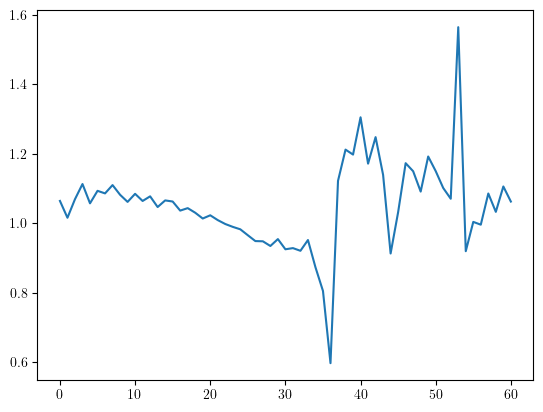

In [20]:
# summary_concat_truth_all.shape
pl.figure()
pl.plot(summary_concat_mock_all/summary_concat_truth_all)


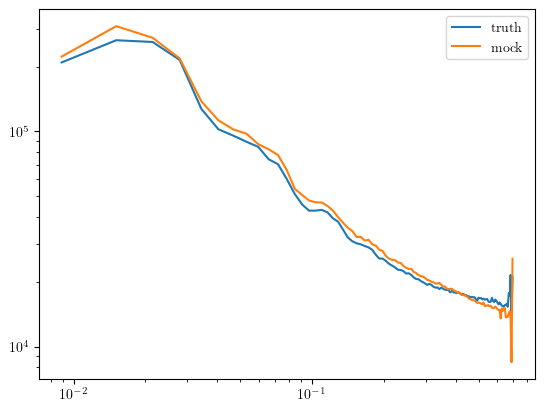

In [11]:
# plot Pk:
pl.figure()
pl.loglog(saved_j['k_Pk'], saved_j['Pk_truth'], label='truth')
pl.loglog(saved_j['k_Pk'], saved_j['Pk_mock'], label='mock')
pl.legend()




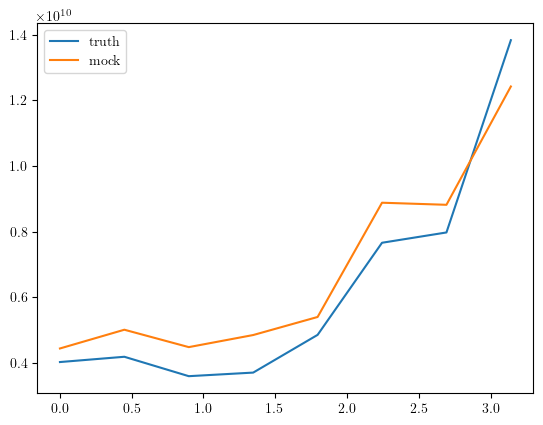

In [12]:
# plot Bk:
pl.figure()
pl.plot(saved_j['theta'], saved_j['Bk_truth_k0p06'], label='truth')
pl.plot(saved_j['theta'], saved_j['Bk_mock_k0p06'], label='mock')
pl.legend()



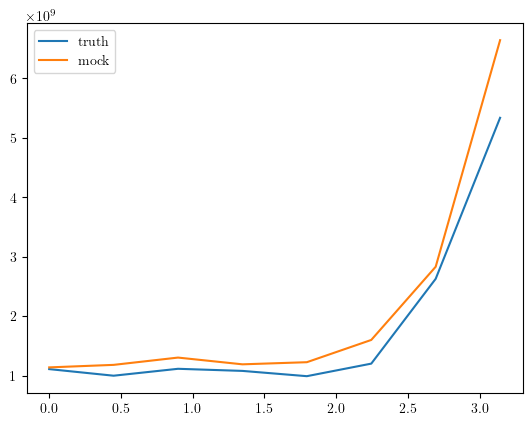

In [13]:
# plot Bk:
pl.figure()
pl.plot(saved_j['theta'], saved_j['Bk_truth_k0p2'], label='truth')
pl.plot(saved_j['theta'], saved_j['Bk_mock_k0p2'], label='mock')
pl.legend()



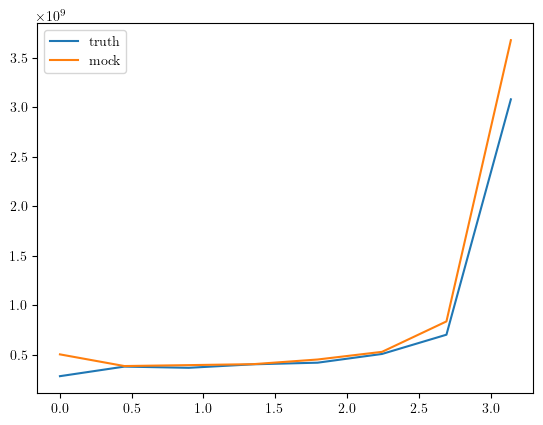

In [14]:
# plot Bk:
pl.figure()
pl.plot(saved_j['theta'], saved_j['Bk_truth_k0p3'], label='truth')
pl.plot(saved_j['theta'], saved_j['Bk_mock_k0p3'], label='mock')
pl.legend()

